## Классификация фруктиков и овощей

In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [2]:
import numpy as np
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import Dataset
import torch
%matplotlib inline 
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from enum import Enum
import pandas as pd
 
import torch.nn as nn
import torch.nn.functional as F 
import os

import torchvision.transforms.functional as FT
import random
from sklearn.model_selection import train_test_split
import sys
from skimage import io, transform
import copy
 
random_seed = 42


_ = torch.manual_seed(42)
 
# Проверяем, доступны ли GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Работа с данными

In [3]:
# Раскомментить, если надо распаковать и переименовать файл
!rm -r data
!unzip 603f8fc619d9540007cf6d88.zip
!cp -r 603f8fc619d9540007cf6d88 data
!rm -r 603f8fc619d9540007cf6d88

rm: cannot remove 'data': No such file or directory
Archive:  603f8fc619d9540007cf6d88.zip
   creating: 603f8fc619d9540007cf6d88/
   creating: 603f8fc619d9540007cf6d88/test/
   creating: 603f8fc619d9540007cf6d88/test/4050_almond_/
 extracting: 603f8fc619d9540007cf6d88/test/4050_almond_/2021-01-11_11-16-54-203879_1610378236.2277915.jpeg  
 extracting: 603f8fc619d9540007cf6d88/test/4050_almond_/2021-01-11_11-17-35-366042_1610439317.0635796.jpeg  
 extracting: 603f8fc619d9540007cf6d88/test/4050_almond_/2021-01-12_13-37-07-274816_1610618333.0583596.jpeg  
 extracting: 603f8fc619d9540007cf6d88/test/4050_almond_/2021-02-17_15-31-38-787005_1614512137.7014427.jpeg  
 extracting: 603f8fc619d9540007cf6d88/test/4050_almond_/2021-02-17_15-33-44-986985_1614473644.2525148.jpeg  
 extracting: 603f8fc619d9540007cf6d88/test/4050_almond_/2021-02-17_15-32-37-387200_1614473618.0030859.jpeg  
 extracting: 603f8fc619d9540007cf6d88/test/4050_almond_/2021-01-11_11-17-28-720904_1610439315.4752197.jpeg  
 extra

In [4]:
data_train_dir = './data/train'
print(os.listdir(data_train_dir))

['4080_grapefruit_', '8906_chilli_-_green', '4069_capsicum_-_red', '8915_onion_-_spring', '9442_chili_yellow', '4079_grape_-_red', '8946_watermelon', '4086_orange_', '4055_croissant_-_butter', '4056_croissant_-_choc_hazelnut', '8922_tomato_-_roma', '4099_mango_-_green', '4064_banana', '4058_doughnut_(sugar)', '4084_onion_-_eschalot', '4071_carrot_-_orange', '4070_capsicum_-_yellow', '4093_tomato_-_cocktail_(large)', '4097_lime', '4059_pretzel', '4060_apple_-_granny_smith', '4083_onion_-_red', '4078_grape_-_green', '4094_zucchini', '4066_broccoli', '4061_apple_-_pink_lady', '8919_kiwifruit_-_gold', '4072_cauliflower', '4082_nectarine_-_yellow', '4050_almond_', '4075_eggplant', '4068_capsicum_-_orange', '4074_cucumber', '4054_walnut', '4096_lemon', '4085_onion_-_white', '4088_potato_', '4076_garlic', '8904_chilli_-_red', '4089_potato_-_sweet', '4077_ginger', '4095_leek', '4081_kiwifruit_-_green', '4087_pineapple', '4092_tomato_-_cherry_(small)', '4090_raspberry', '4067_capsicum_-_green',

In [5]:
data_test_dir = './data/test'
print(os.listdir(data_test_dir))

['4080_grapefruit_', '8906_chilli_-_green', '4069_capsicum_-_red', '8915_onion_-_spring', '9442_chili_yellow', '4079_grape_-_red', '8946_watermelon', '4086_orange_', '4055_croissant_-_butter', '4056_croissant_-_choc_hazelnut', '8922_tomato_-_roma', '4099_mango_-_green', '4064_banana', '4058_doughnut_(sugar)', '4084_onion_-_eschalot', '4071_carrot_-_orange', '4070_capsicum_-_yellow', '4093_tomato_-_cocktail_(large)', '4097_lime', '4059_pretzel', '4060_apple_-_granny_smith', '4083_onion_-_red', '4078_grape_-_green', '4094_zucchini', '4066_broccoli', '4061_apple_-_pink_lady', '8919_kiwifruit_-_gold', '4072_cauliflower', '4082_nectarine_-_yellow', '4050_almond_', '4075_eggplant', '4068_capsicum_-_orange', '4074_cucumber', '4054_walnut', '4096_lemon', '4085_onion_-_white', '4088_potato_', '4076_garlic', '8904_chilli_-_red', '4089_potato_-_sweet', '4077_ginger', '4095_leek', '4081_kiwifruit_-_green', '4087_pineapple', '4092_tomato_-_cherry_(small)', '4090_raspberry', '4067_capsicum_-_green',

### Переименование
Нужно, чтобы потом отличить аугментированнные картинки (и уметь удалять их) от оригинальных

In [6]:
def get_cor_name(cur_class):
    cor_name = cur_class[5:]
    cor_name = cor_name[:-1] if cor_name[-1] == "_" else cor_name
    cor_name = cor_name.replace('-_', '')
    cor_name = cor_name.replace('(', '')
    cor_name = cor_name.replace(')', '')
    return cor_name

Переименуем файлы так, чтобы они содержали названия соответствующих классов:

In [7]:
def rename_files(data_dir):
    classes = os.listdir(data_dir)
    for cur_class in classes:
        cor_name = get_cor_name(cur_class)
        counter = 0
        for file in os.listdir(data_dir + '/' + cur_class): 
            if file.endswith('jpeg'):
                os.rename((data_dir + '/' + cur_class + '/' + file),(data_dir + '/' + cur_class + '/' + cor_name + "_" + str(counter)+".jpeg"))
                counter += 1

In [8]:
# Раскомментить, если надо переименовать файлы
rename_files(data_train_dir)
rename_files(data_test_dir)

### Датасет менеджер

In [9]:
class DataSetManager():
    def __init__(self, make_val=True, val_ratio=0.1):
        self.data_info = {
            'train' : [],
            'val' : [],
            'test' : [],
        }
        self.data = {
            'train' : pd.DataFrame(columns=['path', 'label']),
            'val' : pd.DataFrame(columns=['path', 'label']),
            'test' : pd.DataFrame(columns=['path', 'label']),
        }
        self.make_val = make_val
        self.val_ratio=val_ratio
        self.label_info = []
        self.prepare_val_dir(val_ratio=val_ratio, make_val=self.make_val)

    def prepare_val_dir(self, val_ratio, make_val=False):
        directory = {
          'train' : './data/train/',
          'val'   : './data/val/',
          'test'  : './data/test/',
        }
        if make_val: 
            try: 
                os.mkdir(directory['val']) 
            except OSError as error: 
                print(error, file=sys.stderr)
                
        for label_num, label_dir_name in enumerate(tqdm(os.listdir(directory['train']))):
            if label_dir_name == '4157_other-classifier':
                if make_val:
                    os.mkdir(os.path.join(directory['test'], label_dir_name))
                    imgs_name = os.listdir(directory['train'] + label_dir_name)
                    train_imgs, test_imgs = train_test_split(imgs_name,test_size=self.val_ratio / 2)
                    for test_img in test_imgs:
                        os.rename(os.path.join(directory['train'], label_dir_name, test_img), 
                            os.path.join(directory['test'], label_dir_name, test_img))
                else:
                    test_imgs = []
            else:
                test_imgs = os.listdir(os.path.join(directory['test'], label_dir_name))

      
            if make_val: 
                try: 
                    os.mkdir(os.path.join(directory['val'], label_dir_name))
                except OSError as error: 
                    print(error, file=sys.stderr)  

                imgs_name = os.listdir(directory['train'] + label_dir_name)
                train_imgs, val_imgs = train_test_split(imgs_name,test_size=self.val_ratio)
                for val_img in val_imgs:
                    os.rename(os.path.join(directory['train'], label_dir_name, val_img), 
                        os.path.join(directory['val'], label_dir_name, val_img))
            else:
                train_imgs = os.listdir(os.path.join(directory['train'], label_dir_name))
                val_imgs = os.listdir(os.path.join(directory['val'], label_dir_name))
            for imgs, dataset_part in zip([train_imgs, val_imgs, test_imgs], ['train', 'val', 'test']):
                for img in imgs:
                    path = os.path.join(directory[dataset_part], label_dir_name, img)
                    self.data[dataset_part] = self.data[dataset_part].append(pd.Series([path, label_num], index=self.data[dataset_part].columns), ignore_index=True)
          
            self.label_info.append({
                'label_name' : label_dir_name[5:],
                'label_code' : label_dir_name[:4],
                'sub_path'   : label_dir_name,
              })

    def get_data(self):
        return self.data
  
    def get_class(self, label_num):
        return self.label_info[label_num]['label_name']

    def num_classes(self):
        return len(self.label_info)

    def GetDataSet(self, dataset_part, transform):
        return FreshDataset(dataset_part, self.data[dataset_part], transform=transform)

In [10]:
dataset_manager = DataSetManager(make_val=True)

  0%|          | 0/58 [00:00<?, ?it/s]

### Добавление аугментации

In [11]:
class AugConfig(Enum):
    NEW_IMG_COUNT = 2
    
    BRIGHTNESS_RANDOM_LEFT = 0.5
    BRIGHTNESS_RANDOM_RIGHT =  1.5
    
    CONTRAST_RANDOM_LEFT = 0.5
    CONTRAST_RANDOM_RIGHT =  1.5
    
    SATURATION_RANDOM_LEFT = 0.5
    SATURATION_RANDOM_RIGHT =  1.5
    
    HUE_RANDOM_LEFT = -18
    HUE_RANDOM_RIGHT =  18
    
    ANGLE_MIN = -50
    ANGLE_MAX = 50
    
    IMG_SIZE_MIN = 224
    IMG_SIZE_MAX = 528

In [12]:
def get_new_random_image(image):
    new_image = image
    
    # Рандомно отразим / не отразим картинку 
    random_val = random.randint(0, 1)
    if random_val:
        new_image = FT.hflip(new_image)
        
    # Рандомно изменим / не изменим яркость 
    random_val = random.randint(0, 1)
    if random_val:
        new_image = FT.adjust_brightness(new_image, 
                                         random.uniform(AugConfig.BRIGHTNESS_RANDOM_LEFT.value, AugConfig.BRIGHTNESS_RANDOM_RIGHT.value))
        
    # Рандомно изменим / не изменим контрастность 
    random_val = random.randint(0, 1)
    if random_val:
        new_image = FT.adjust_contrast(new_image,
                                       random.uniform(AugConfig.CONTRAST_RANDOM_LEFT.value, AugConfig.CONTRAST_RANDOM_RIGHT.value))
        
    # Рандомно изменим / не изменим насыщенность 
    random_val = random.randint(0, 1)
    if random_val:
        new_image = FT.adjust_saturation(new_image, 
                                         random.uniform(AugConfig.SATURATION_RANDOM_LEFT.value, AugConfig.SATURATION_RANDOM_RIGHT.value))
        
    # Рандомно изменим / не изменим оттенки
    random_val = random.randint(0, 1)
    if random_val:
        new_image = FT.adjust_hue(new_image, 
                                  random.uniform(AugConfig.HUE_RANDOM_LEFT.value / 255., AugConfig.HUE_RANDOM_RIGHT.value / 255.))
        
    # Рандомно повернём / не повернём картинку
    random_val = random.randint(0, 1)
    if random_val:
        new_image = FT.rotate(new_image, random.uniform(AugConfig.ANGLE_MIN.value, AugConfig.ANGLE_MAX.value))
        
    # Рандомно обрежем / не обрежем картинку
    random_val = random.randint(0, 1)
    if random_val:
        new_image = FT.center_crop(new_image, random.randint(AugConfig.IMG_SIZE_MIN.value, AugConfig.IMG_SIZE_MAX.value))
    
    return new_image

In [13]:
def get_aug(data_dir):
    random.seed(42)
    classes = os.listdir(data_dir)
    for cur_class in classes:
        for file in os.listdir(data_dir + '/' + cur_class):
            if file.endswith('jpeg'):
                img = Image.open(data_dir + '/' + cur_class + '/' + file).convert('RGB')
            
                for i in range(AugConfig.NEW_IMG_COUNT.value):
                    new_image = get_new_random_image(img)
                    if new_image != img:
                        new_image.save(data_dir + '/' + cur_class + '/' + os.path.splitext(file)[0] + '_' + str(i) + '.jpeg')

In [14]:
get_aug(data_train_dir)

### Датасет

In [15]:
class FreshDataset(Dataset):
    def __init__(self, dataset_type, data, transform=transform):
        self.data = data
        self.transform = transform
        self.dataset_type = dataset_type
        
    def __len__(self):
        return self.data.shape[0]


    def getitem_notransform(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.data.iloc[idx]['path']
        image = io.imread(img_name)
        
        sample =  [image, self.data.iloc[idx]['label']]
        
        return sample

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.data.iloc[idx]['path']
        image = io.imread(img_name)
        
        sample =  [image, self.data.iloc[idx]['label'], idx]
        if self.transform:
            sample[0] = self.transform(sample[0])

        return sample

### Отрисовка

In [16]:
import math
def as_list(x):
    if type(x) is int:
        return [x]
    else:
        return x

def img_show(dataset, idxes, preds=None):
    idxes = as_list(idxes)
    idxes = np.array(idxes)
    num_idxes = len(idxes)
    num_rows = math.ceil(num_idxes / 5)
    fig, ax = plt.subplots(ncols=5, nrows=num_rows, figsize=(20, num_rows * 5))
    for i, idx in enumerate(idxes):
        im, label = dataset.getitem_notransform(idx)
        im_name=dataset_manager.get_class(label)
        ax.flat[i].imshow(im, animated=True)
        if preds is None:
            ax.flat[i].set_title(f'{label}-' + im_name)
        else:
            error_name=dataset_manager.get_class(preds[i])  
            ax.flat[i].set_title(f'{label}-' + im_name + f'\n vs {preds[i]}-{error_name}')
            
def img_show_all(images):
    im = images.permute([1,2,0])
    im = plt.imshow(im, animated=True) 

### Объявление датасетов

In [17]:
stats = ([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])

train_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize(*stats)
    ])

val_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize(*stats)
    ])

test_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize(*stats)
    ])

In [18]:
train_dataset = FreshDataset('train', dataset_manager.get_data()['train'], transform=train_transforms)
val_dataset = FreshDataset('val', dataset_manager.get_data()['val'], transform=val_transforms)
test_dataset = FreshDataset('test', dataset_manager.get_data()['test'], transform=test_transforms)

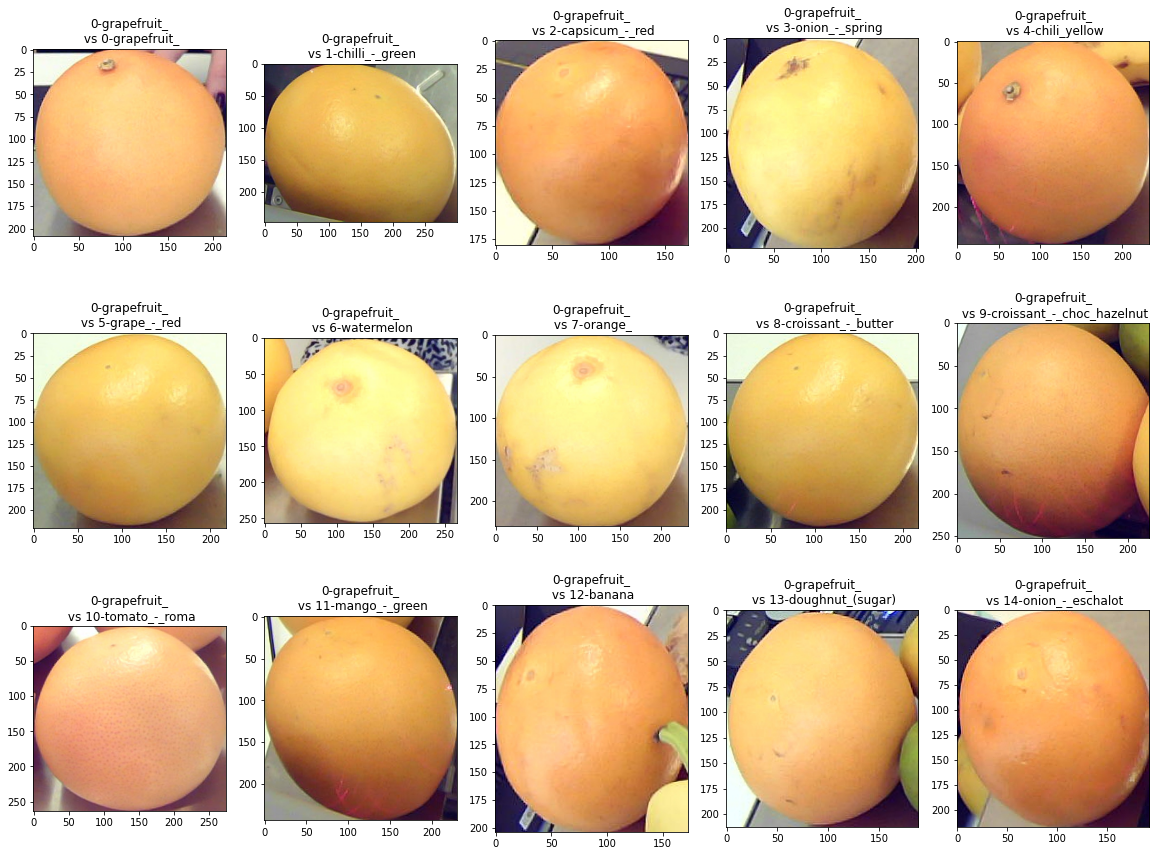

In [19]:
img_show(train_dataset, np.arange(15), preds=np.arange(15))

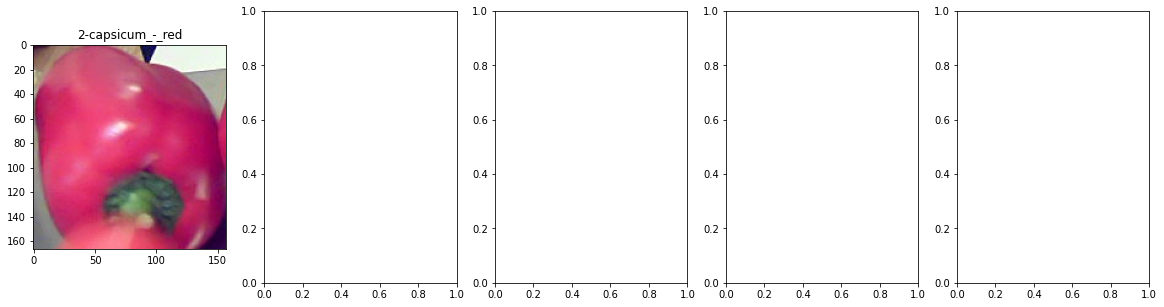

In [20]:
img_show(train_dataset, 500)

### Модель

In [21]:
class ModelConfig(Enum):
    BATCH_SIZE = 100
    
    CRITERION = nn.CrossEntropyLoss()
    OPTIMIZER_FUNC = torch.optim.Adam

    FIRST_NUM_EPOCHS = 15
    FIRST_LR = 0.002
    FIRST_LR_SCHEDULER_STEP_SIZE = 10
    FIRST_LR_SCHEDULER_GAMMA = 0.9
    
    SECOND_NUM_EPOCHS = 15
    SECOND_LR = 0.0001
    SECOND_LR_SCHEDULER_STEP_SIZE = 10
    SECOND_LR_SCHEDULER_GAMMA = 0.9
    
    UNFREEZE_NUM_EPOCHS = 20
    UNFREEZE_LR = 0.0001
    UNFREEZE_LR_SCHEDULER_STEP_SIZE = 10
    UNFREEZE_LR_SCHEDULER_GAMMA = 0.9

In [22]:
batch_size = ModelConfig.BATCH_SIZE.value
dataloaders = {
    'train' : DataLoader(dataset=train_dataset,
           batch_size=batch_size,
           shuffle=True, num_workers=2),
    
    'val' : DataLoader(dataset=val_dataset,
           batch_size=batch_size,
           shuffle=True, num_workers=2),
    
    'test' : DataLoader(dataset=test_dataset,
           batch_size=batch_size,
           shuffle=False, num_workers=2),
} 
dataset_sizes = {'train': len(train_dataset),
                 'val': len(val_dataset)}

In [23]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, start_epoch = 1):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(start_epoch, start_epoch + num_epochs):
        print('Epoch {}/{}'.format(epoch, start_epoch + num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels, _ in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [24]:
def check_model(model):
    num_classes = dataset_manager.num_classes()
    phase = 'test'
    batch_loss = 0.0
    confusion_matrix = torch.zeros(num_classes, num_classes)
    batch_corrects = 0
    errors = []
    model.eval()
    with torch.no_grad():
        for inputs, labels, idxes in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)            
            
            loss = criterion(outputs, labels)

            # statistics
            batch_loss += loss.item() * inputs.size(0)
            batch_corrects += torch.sum(preds == labels.data)

            for i, (t, p) in enumerate(zip(labels.data.view(-1), preds.view(-1))):
                confusion_matrix[t.long(), p.long()] += 1
                if (t != p):
                    errors.append([idxes[i], p.cpu()])


    epoch_loss = batch_loss / len(test_dataset)
    epoch_acc = batch_corrects.double() / len(test_dataset)
        
    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        phase, epoch_loss, epoch_acc))
    errors = np.array(errors).T
    return confusion_matrix, errors

In [25]:
def get_model(num_classes):
    model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(512, num_classes)
    return model

In [26]:
def un_freeze_model(model):
    for param in model.parameters():
        param.requires_grad = True
    return model

In [27]:
num_classes = dataset_manager.num_classes()
net = get_model(num_classes).to(device)


num_epochs = ModelConfig.FIRST_NUM_EPOCHS.value
learning_rate = ModelConfig.FIRST_LR.value
criterion = ModelConfig.CRITERION.value
optimizer = ModelConfig.OPTIMIZER_FUNC.value(net.parameters(), lr=learning_rate)
lr_scheduler_step_size = ModelConfig.FIRST_LR_SCHEDULER_STEP_SIZE.value
lr_scheduler_gamma = ModelConfig.FIRST_LR_SCHEDULER_GAMMA.value
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=lr_scheduler_step_size, 
                                            gamma=lr_scheduler_gamma)


Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /home/asbeloborodova/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/asbeloborodova/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [28]:
net = train_model(net, criterion, optimizer, scheduler, num_epochs)

Epoch 1/15
----------
train Loss: 0.9310 Acc: 0.8093
val Loss: 0.2623 Acc: 0.9525

Epoch 2/15
----------
train Loss: 0.2037 Acc: 0.9616
val Loss: 0.1595 Acc: 0.9627

Epoch 3/15
----------
train Loss: 0.1330 Acc: 0.9737
val Loss: 0.1131 Acc: 0.9796

Epoch 4/15
----------
train Loss: 0.0991 Acc: 0.9796
val Loss: 0.0944 Acc: 0.9791

Epoch 5/15
----------
train Loss: 0.0788 Acc: 0.9850
val Loss: 0.0863 Acc: 0.9786

Epoch 6/15
----------
train Loss: 0.0675 Acc: 0.9857
val Loss: 0.0666 Acc: 0.9862

Epoch 7/15
----------
train Loss: 0.0576 Acc: 0.9881
val Loss: 0.0692 Acc: 0.9852

Epoch 8/15
----------
train Loss: 0.0496 Acc: 0.9897
val Loss: 0.0606 Acc: 0.9837

Epoch 9/15
----------
train Loss: 0.0454 Acc: 0.9907
val Loss: 0.0617 Acc: 0.9847

Epoch 10/15
----------
train Loss: 0.0390 Acc: 0.9926
val Loss: 0.0511 Acc: 0.9877

Epoch 11/15
----------
train Loss: 0.0360 Acc: 0.9932
val Loss: 0.0545 Acc: 0.9832

Epoch 12/15
----------
train Loss: 0.0342 Acc: 0.9928
val Loss: 0.0478 Acc: 0.9872

E

test Loss: 0.0404 Acc: 0.9885


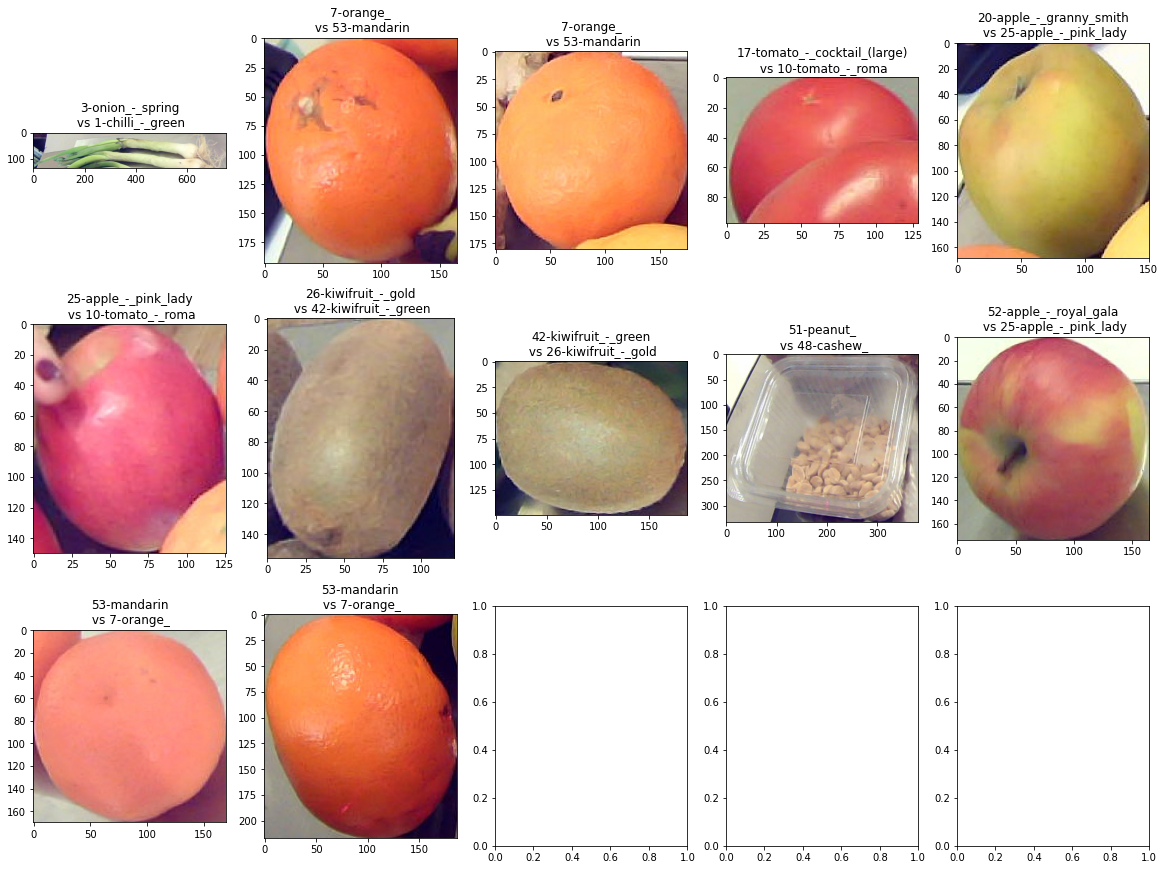

In [29]:
cf_test, errors = check_model(net)
img_show(test_dataset, errors[0], preds=errors[1])

In [30]:
prev_num_epochs = ModelConfig.FIRST_NUM_EPOCHS.value
num_epochs = ModelConfig.SECOND_NUM_EPOCHS.value
learning_rate = ModelConfig.SECOND_LR.value
optimizer = ModelConfig.OPTIMIZER_FUNC.value(net.parameters(), lr=learning_rate)
lr_scheduler_step_size = ModelConfig.SECOND_LR_SCHEDULER_STEP_SIZE.value
lr_scheduler_gamma = ModelConfig.SECOND_LR_SCHEDULER_GAMMA.value
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=lr_scheduler_step_size, 
                                            gamma=lr_scheduler_gamma)

In [31]:
net = train_model(net, criterion, optimizer, scheduler, num_epochs, prev_num_epochs + 1)

Epoch 16/30
----------
train Loss: 0.0207 Acc: 0.9966
val Loss: 0.0368 Acc: 0.9903

Epoch 17/30
----------
train Loss: 0.0206 Acc: 0.9961
val Loss: 0.0375 Acc: 0.9898

Epoch 18/30
----------
train Loss: 0.0209 Acc: 0.9960
val Loss: 0.0377 Acc: 0.9898

Epoch 19/30
----------
train Loss: 0.0206 Acc: 0.9967
val Loss: 0.0389 Acc: 0.9883

Epoch 20/30
----------
train Loss: 0.0196 Acc: 0.9966
val Loss: 0.0418 Acc: 0.9862

Epoch 21/30
----------
train Loss: 0.0193 Acc: 0.9971
val Loss: 0.0374 Acc: 0.9898

Epoch 22/30
----------
train Loss: 0.0189 Acc: 0.9970
val Loss: 0.0354 Acc: 0.9898

Epoch 23/30
----------
train Loss: 0.0188 Acc: 0.9968
val Loss: 0.0379 Acc: 0.9898

Epoch 24/30
----------
train Loss: 0.0188 Acc: 0.9971
val Loss: 0.0382 Acc: 0.9918

Epoch 25/30
----------
train Loss: 0.0186 Acc: 0.9972
val Loss: 0.0401 Acc: 0.9898

Epoch 26/30
----------
train Loss: 0.0188 Acc: 0.9968
val Loss: 0.0400 Acc: 0.9898

Epoch 27/30
----------
train Loss: 0.0184 Acc: 0.9968
val Loss: 0.0398 Acc: 

test Loss: 0.0301 Acc: 0.9923


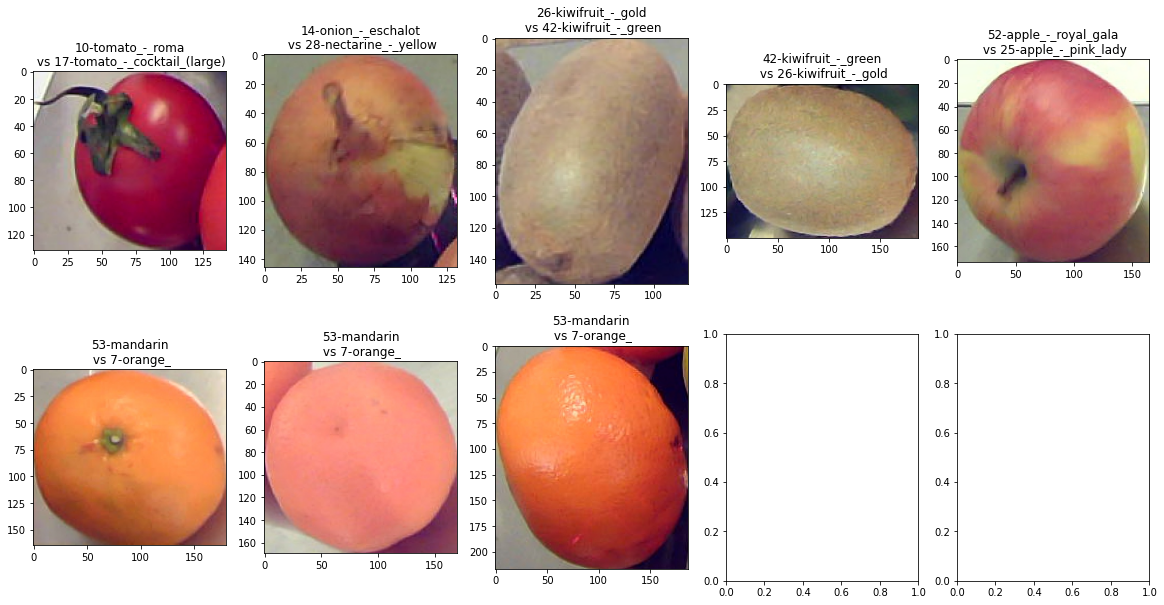

In [32]:
cf_test, errors = check_model(net)
img_show(test_dataset, errors[0], preds=errors[1])

In [33]:
prev_num_epochs = ModelConfig.SECOND_NUM_EPOCHS.value + ModelConfig.FIRST_NUM_EPOCHS.value
num_epochs = ModelConfig.UNFREEZE_NUM_EPOCHS.value
learning_rate = ModelConfig.UNFREEZE_LR.value
optimizer = ModelConfig.OPTIMIZER_FUNC.value(net.parameters(), lr=learning_rate)
lr_scheduler_step_size = ModelConfig.UNFREEZE_LR_SCHEDULER_STEP_SIZE.value
lr_scheduler_gamma = ModelConfig.UNFREEZE_LR_SCHEDULER_GAMMA.value
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=lr_scheduler_step_size, 
                                            gamma=lr_scheduler_gamma)

In [34]:
net = un_freeze_model(net)
net = train_model(net, criterion, optimizer, scheduler, num_epochs, prev_num_epochs + 1)

Epoch 31/50
----------
train Loss: 0.0500 Acc: 0.9849
val Loss: 0.0480 Acc: 0.9872

Epoch 32/50
----------
train Loss: 0.0233 Acc: 0.9933
val Loss: 0.0251 Acc: 0.9908

Epoch 33/50
----------
train Loss: 0.0157 Acc: 0.9957
val Loss: 0.0318 Acc: 0.9913

Epoch 34/50
----------
train Loss: 0.0087 Acc: 0.9976
val Loss: 0.0140 Acc: 0.9959

Epoch 35/50
----------
train Loss: 0.0042 Acc: 0.9988
val Loss: 0.0156 Acc: 0.9949

Epoch 36/50
----------
train Loss: 0.0126 Acc: 0.9971
val Loss: 0.0244 Acc: 0.9929

Epoch 37/50
----------
train Loss: 0.0093 Acc: 0.9970
val Loss: 0.0218 Acc: 0.9949

Epoch 38/50
----------
train Loss: 0.0198 Acc: 0.9935
val Loss: 0.0684 Acc: 0.9832

Epoch 39/50
----------
train Loss: 0.0136 Acc: 0.9953
val Loss: 0.0297 Acc: 0.9923

Epoch 40/50
----------
train Loss: 0.0060 Acc: 0.9984
val Loss: 0.0143 Acc: 0.9959

Epoch 41/50
----------
train Loss: 0.0037 Acc: 0.9987
val Loss: 0.0195 Acc: 0.9939

Epoch 42/50
----------
train Loss: 0.0057 Acc: 0.9984
val Loss: 0.0178 Acc: 

test Loss: 0.0105 Acc: 0.9962


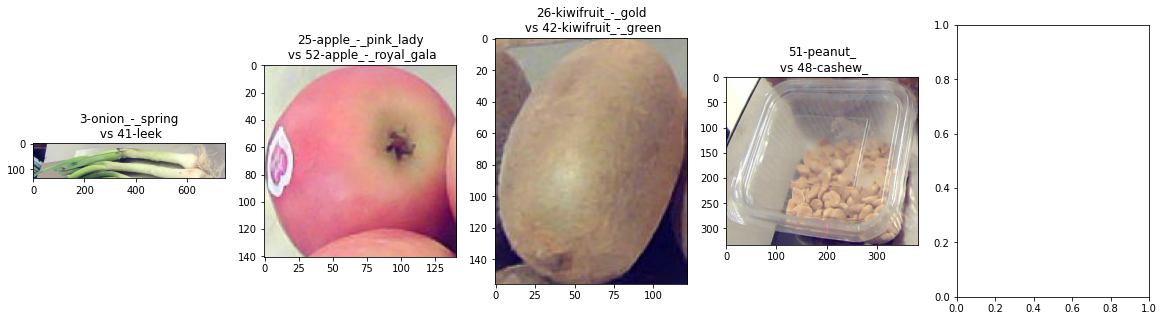

In [35]:
cf_test, errors = check_model(net)
img_show(test_dataset, errors[0], preds=errors[1])

## Удалим сгенерированные картинки

In [36]:
def del_aug(data_dir):
    classes = os.listdir(data_dir)
    for cur_class in classes:
        for file in os.listdir(data_dir + '/' + cur_class):
            if file.endswith('jpeg') and file.split('_')[-2].isdigit():
                os.remove(data_dir + '/' + cur_class + '/' + file)

In [37]:
del_aug(data_test_dir)